In [1]:
from Bio import SeqIO, Entrez
import os
from urllib.error import HTTPError
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import permutations, product
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
import tqdm
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score

from numpy import mean
from numpy import std
import pickle
from os import path
from sklearn.model_selection import cross_val_score
from warnings import simplefilter
from collections import OrderedDict
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score

from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier

from sklearn.model_selection import GridSearchCV

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)

Entrez.tool = "Zoonosis predictor"

Entrez.email = input("Enter an email address to use NCBI e-utils: ")

In [2]:
def saveModel(model, name, X_test, y_test, params=None, dir='models/curr_models', gradBoost=False, xgBoost=False):
    if not path.exists(f"{dir}/{name}.pkl"):
        print("does not exist")

        pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))
    else:
        predictions = model.predict(X_test)
        currAcc = accuracy_score(y_test, predictions)

        pickled_model = pickle.load(open(f'{dir}/{name}.pkl', 'rb'))
        
        if gradBoost:
            # get features here 
            cols_when_model_builds = pickled_model.feature_names_in_
            X_test=X_test[cols_when_model_builds]
        elif xgBoost:
            # put features into the same order that the model was trained in
            cols_when_model_builds = pickled_model.get_booster().feature_names
            X_test=X_test[cols_when_model_builds]
        
        # .values?
        
        picklePredictions=pickled_model.predict(X_test)
        pickleAcc=accuracy_score(y_test, picklePredictions)
        
        if currAcc > pickleAcc:
            print("update!")

            # TP, FP, FN, TN
            print(confusion_matrix(y_test, picklePredictions).ravel())

            print("curr", currAcc, "pickle", pickleAcc)
            pickle.dump(model, open(f'{dir}/{name}.pkl', 'wb'))

            if params != None:
                pickle.dump(params, open(f'{dir}/{name}-params.pkl', 'wb'))
        else:
            print("no update")
            print("curr", currAcc, "pickle", pickleAcc)
            
            # TP, FP, FN, TN
            print(confusion_matrix(y_test, picklePredictions).ravel())

            model=pickled_model
    return model

In [3]:
def resetkmerdict(permset)->OrderedDict:
        kmerdict = OrderedDict()
        for i in permset:
            kmerdict[i]=0
        return kmerdict

def assign_kmers_to_dict(st, permset, kmer):
    kmerdict=resetkmerdict(permset)
    # st = row[2] # tune for which column the sequence is in
    for j in range(len(st)-kmer+1):
        if not st[j:j+kmer] in permset: continue
        kmerdict[st[j:j+kmer]]+=1
    return kmerdict

def getTrainParams(mergedDf, kmer):

    s = product('acgt',repeat = kmer)
    permset = set(["".join(x) for x in list(s)])
    # print(permset)

    l = []
    
    for row in tqdm.tqdm(mergedDf.itertuples()):
        # print(row)
        l.append(assign_kmers_to_dict(row[2], permset, kmer))

    finalkmerdict=pd.DataFrame(l)
    # print(finalkmerdict)

    # print("finished")
    # mergedDf.fillna(0, inplace=True)

    X = finalkmerdict
    X = X.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)
    Y = mergedDf['isZoonotic']

    

    # print(X)
    # print(Y)
    return (X, Y)

In [4]:
def queryKmer(ID, isZoonotic_list, index, everything):
    FileName = "{}.gb".format(ID)
    try:
        QueryHandle = Entrez.efetch(db="nucleotide", id=ID, 
                                    rettype="gb", retmode="text")
    except HTTPError as Error:
        if Error.code == 400:  # Bad request
            raise ValueError(f"Accession number not found: {ID}")
        else:
            raise

    SeqRec = SeqIO.read(QueryHandle, "genbank")
    info = {'accession': ID, 'sequence': str(SeqRec.seq).lower(), 'isZoonotic': isZoonotic_list[index]}
    everything.append(info)

    pickle.dump(info, open(f"data/sequences/{ID}.pkl", "wb"))

In [5]:
def getSequences(mergedDf):
    accession_list = [] # maintain order
    isZoonotic_list = [] # maintain order
    accession_set = set()
    isZoonotic_set = set()


    for row in tqdm.tqdm(mergedDf.itertuples()):
        # row[13] = accession, row[15] = infects humans
        for single_acc in row[14].split("; "):
            # print(single_acc)
            if single_acc not in accession_set:
                accession_list.append(single_acc)
                isZoonotic_list.append(0 if not row[16] else 1)
                # accession_set.add(single_acc)
                # isZoonotic_set.add(row[15])
                # print(0 if not row[16] else 1)

    print("passed local retrieval")
    # TODO: RUN MULTIPLE THREADS TO SPEED UP
    threads = []
    vals = []

    print(len(accession_list))
    for index, ID in enumerate(tqdm.tqdm(accession_list[1000:1848])): #only read the first 100 lol
        # multithread for speed up
        queryKmer(ID, isZoonotic_list, index, vals)
        # x = threading.Thread(target=queryKmer, args=(ID, isZoonotic_list, index, vals))
        # threads.append(x)
        # x.start()

    # for index, thread in enumerate(tqdm.tqdm(threads)):
    #     thread.join()
    df = pd.DataFrame(vals)
    df.to_csv("data/nardus_sequences.csv")

    return df
    


In [66]:
# SLOW METHOD
mergedDf = pd.read_csv("data/FinalData_Cleaned.csv") # read mollentze data
print(len(mergedDf))
sequences = getSequences(mergedDf)
(X_test, y_test) = getTrainParams(sequences, 4)

913


913it [00:00, 581092.50it/s]


passed local retrieval
1848


  3%|▎         | 25/848 [00:10<05:26,  2.52it/s]/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/Bio/GenBank/Scanner.py:1794: BiopythonParserWarning: Structured comment not parsed for NC_034212. Is it malformed?
  warnings.warn(
  3%|▎         | 26/848 [00:11<05:20,  2.56it/s]/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/Bio/GenBank/Scanner.py:1794: BiopythonParserWarning: Structured comment not parsed for NC_034213. Is it malformed?
  warnings.warn(
  3%|▎         | 27/848 [00:11<05:21,  2.55it/s]/Users/benjaminli/opt/miniconda3/envs/seq/lib/python3.8/site-packages/Bio/GenBank/Scanner.py:1794: BiopythonParserWarning: Structured comment not parsed for NC_034211. Is it malformed?
  warnings.warn(
100%|██████████| 848/848 [05:47<00:00,  2.44it/s]
848it [00:01, 769.22it/s]


In [67]:
print(sequences['isZoonotic'])
print(len(X_test))
print(len(y_test))

0      0
1      0
2      0
3      1
4      1
      ..
843    1
844    1
845    1
846    1
847    1
Name: isZoonotic, Length: 848, dtype: int64
848
848


In [6]:
# FAST METHOD - LOAD DATA FROM FOLDER
li = []
for f in os.listdir('data/sequences'):
    seqdf = pickle.load(open(f'data/sequences/{f}', 'rb'))
    li.append(seqdf)
df = pd.DataFrame(li)
print(df)

# print(df)
(X_test_temp, y_test_temp) = getTrainParams(df, 4)


        accession                                           sequence  \
0     NC_018629.1  acgcttaacagctaaaaaccagaagacagagaaggaatcgaagggg...   
1     NC_038446.1  tagtagtagactccttgaaaagctactactacaaagactgggatga...   
2     NC_002324.1  acacaaagtcctgggcaaaagaaaagcaaaataaccaactatagat...   
3     NC_006507.1  agcaaaaacaggcagtcaaaatggctacagaccagatggacatctc...   
4     NC_004119.1  agttggttttgccggctacaacgatcctccgtaggaagcgttggtg...   
...           ...                                                ...   
1843  NC_030117.1  ggctcaagcctctcgcggctgtgcaagtggaaaaaaaattttttta...   
1844  NC_018481.1  cgcactggggatccgagttaaagtatcaatcttccgtgtataatct...   
1845   KP792660.1  taaagcaatggcgcatcaacttggagagatagtgaggcagtttgct...   
1846   KU925448.1  atgtctgtcttagactttaccgacatccgtggtctgaatgattggt...   
1847  NC_023819.1  gttcttttgccactatgaagcttggctatgtgccaccagtgtatga...   

      isZoonotic  
0              1  
1              0  
2              0  
3              1  
4              0  
...          ...  
18

1848it [00:06, 287.63it/s]


In [7]:
best_gradBoost = pickle.load(open('models/curr_models/gradBoost.pkl', 'rb'))
best_xgBoost = pickle.load(open('models/curr_models/xgBoost.pkl', 'rb'))

kmer = 4
s = product('acgt',repeat = kmer)
permset = set(["".join(x) for x in list(s)])

pred_arr = []
xg_pred = []

# blood validation
for ind, file in enumerate(os.listdir("data/virome_contigs")):
    fasta_sequences = SeqIO.parse(open(f"data/virome_contigs/{file}"),'fasta')

    fasta = [x for x in fasta_sequences][0]
    # print(fasta)
    
    name, sequence = fasta.id, str(fasta.seq)
    X_info = sequence.lower()

    oDict = assign_kmers_to_dict(X_info, permset, kmer) # convert ordereddict to pandas dataframe

    kmer_df = pd.DataFrame()

    for i in oDict:
        kmer_df.at[0, i]=oDict[i]

    kmer_df = kmer_df.apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)
    
    cols_when_model_builds = best_gradBoost.feature_names_in_
    kmer_df=kmer_df[cols_when_model_builds]
    
    # print(kmer_df.to_string())
    
    pred_arr.append(best_gradBoost.predict(kmer_df))
    
    cols_when_model_builds = best_xgBoost.get_booster().feature_names
    kmer_df=kmer_df[cols_when_model_builds]
    # print(kmer_df.to_string())

    xg_pred.append(best_xgBoost.predict(kmer_df))
    
pred_arr = np.asarray(pred_arr)
xg_pred = np.asarray(xg_pred)


    # print(best_gradBoost.predict(kmer_df), sequences.loc[ind]['isZoonotic'])
    # print(best_gradBoost.predict(kmer_df), sequences['isZoonotic'])
        # print(accuracy_score())

In [8]:
print(len(X_test_temp), len(y_test_temp))

1848 1848


In [9]:
cols_when_model_builds = best_gradBoost.feature_names_in_
X_test_temp=X_test_temp[cols_when_model_builds]
print(len(X_test_temp))
print(accuracy_score(y_test_temp, best_gradBoost.predict(X_test_temp)))
print(confusion_matrix(y_test_temp, best_gradBoost.predict(X_test_temp)).ravel())

# print(y_test.to_string())

cols_when_model_builds = best_xgBoost.get_booster().feature_names
X_test_temp=X_test_temp[cols_when_model_builds]
print(accuracy_score(y_test_temp, best_xgBoost.predict(X_test_temp)))
print(confusion_matrix(y_test_temp, best_gradBoost.predict(X_test_temp)).ravel())


1848
0.79004329004329
[1326   28  360  134]
0.7922077922077922
[1326   28  360  134]


In [10]:
print(X_test_temp)

          tggc      ttcc      tatg      gtat      aatg      acag      atgg  \
0     0.129032  0.296774  0.341935  0.193548  0.406452  0.393548  0.412903   
1     0.291667  0.291667  0.541667  0.458333  0.541667  0.333333  0.625000   
2     0.138462  0.276923  0.353846  0.307692  0.400000  0.123077  0.246154   
3     0.315789  0.263158  0.105263  0.105263  0.473684  0.473684  0.526316   
4     0.540146  0.218978  0.240876  0.094891  0.693431  0.335766  0.715328   
...        ...       ...       ...       ...       ...       ...       ...   
1843  0.063178  0.157752  0.276744  0.219767  0.310078  0.110078  0.229070   
1844  0.280000  0.240000  0.160000  0.160000  0.340000  0.220000  0.260000   
1845  0.226804  0.144330  0.453608  0.247423  0.587629  0.340206  0.422680   
1846  0.550000  0.250000  0.300000  0.150000  0.800000  0.800000  0.500000   
1847  0.309524  0.452381  0.547619  0.428571  0.666667  0.166667  0.547619   

          tact      tcaa      aggc  ...      ggca      gacc    

In [18]:
orig_df = pd.read_csv('data/info.csv')
X_vals = pd.concat([orig_df.loc[:, orig_df.columns != 'isZoonotic'], X_test_temp], axis=0, ignore_index=True)

# # print(X_vals)
y_vals = pd.concat([orig_df['isZoonotic'], y_test_temp], axis=0, ignore_index=True)

X_train, X_test, y_train, y_test = train_test_split(X_vals, y_vals, test_size=0.2, random_state=1)

# print(len(X_train)+len(X_test))

In [16]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":130, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":9,
    "random_state":0,
    "min_sample_split":25,
    "subsample":0.85
    # "warm_start":True
}


# careful with WARM START - only works after a lot of iterations
# integrating both datasets works better!

print(len(X_train)+len(X_test))
for learning_rate in lr_list:
    gradBoost = GradientBoostingClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, max_features=parameters['max_features'], 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample']
    )

    parameters['learning_rate']=learning_rate
    gradBoost.fit(X_train, y_train)

    cols_when_model_builds = gradBoost.feature_names_in_
    X_test=X_test[cols_when_model_builds]
    
    testingAcc = accuracy_score(y_test, gradBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, gradBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    saveModel(gradBoost, "gradBoost", X_test, y_test, parameters, gradBoost=True, dir="models/nardus_testing")

11278
Learning rate:  0.05
Accuracy score (validation): 0.938
update!
[1866   26  115  249]
curr 0.9379432624113475 pickle 0.9375
Learning rate:  0.075
Accuracy score (validation): 0.932
no update
curr 0.9317375886524822 pickle 0.9379432624113475
[1874   18  122  242]
Learning rate:  0.1
Accuracy score (validation): 0.935
no update
curr 0.9348404255319149 pickle 0.9379432624113475
[1874   18  122  242]
Learning rate:  0.15
Accuracy score (validation): 0.931
no update
curr 0.9312943262411347 pickle 0.9379432624113475
[1874   18  122  242]
Learning rate:  0.2
Accuracy score (validation): 0.941
update!
[1874   18  122  242]
curr 0.9406028368794326 pickle 0.9379432624113475
Learning rate:  0.25
Accuracy score (validation): 0.933
no update
curr 0.9330673758865248 pickle 0.9406028368794326
[1863   29  105  259]
Learning rate:  0.3
Accuracy score (validation): 0.935
no update
curr 0.9352836879432624 pickle 0.9406028368794326
[1863   29  105  259]
Learning rate:  0.35
Accuracy score (validatio

In [29]:
learning_rate = 0.05

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":9,
    "random_state":0,
    "min_sample_split":25,
    "subsample":0.85
    # "warm_start":True
}


param_test1 = {'n_estimators':range(100,150,10), 'learning_rate':[0.1,0.15, 0.2,0.25,0.3], 'subsample':[0.8,0.85,0.9], 'max_depth':range(6,10,1), 'min_samples_split':range(10,40,10)}

gradBoost = GridSearchCV(estimator = GradientBoostingClassifier(
    n_estimators=parameters['n_estimators'], 
learning_rate=learning_rate, max_features=parameters['max_features'], 
max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
min_samples_split=parameters['min_sample_split'], subsample=parameters['subsample']
), 
param_grid = param_test1, scoring='roc_auc',n_jobs=-1, cv=5, verbose=10)

parameters['learning_rate']=learning_rate
gradBoost.fit(X_train, y_train)

pickle.dump(gradBoost, open('models/nardus_gridsearch.pkl', 'wb'))

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
[CV 5/5; 1/900] START learning_rate=0.1, max_depth=6, min_samples_split=10, n_estimators=100, subsample=0.8
[CV 1/5; 1/900] START learning_rate=0.1, max_depth=6, min_samples_split=10, n_estimators=100, subsample=0.8
[CV 2/5; 1/900] START learning_rate=0.1, max_depth=6, min_samples_split=10, n_estimators=100, subsample=0.8
[CV 5/5; 2/900] START learning_rate=0.1, max_depth=6, min_samples_split=10, n_estimators=100, subsample=0.85
[CV 3/5; 2/900] START learning_rate=0.1, max_depth=6, min_samples_split=10, n_estimators=100, subsample=0.85
[CV 4/5; 2/900] START learning_rate=0.1, max_depth=6, min_samples_split=10, n_estimators=100, subsample=0.85
[CV 1/5; 2/900] START learning_rate=0.1, max_depth=6, min_samples_split=10, n_estimators=100, subsample=0.85
[CV 3/5; 1/900] START learning_rate=0.1, max_depth=6, min_samples_split=10, n_estimators=100, subsample=0.8
[CV 2/5; 2/900] START learning_rate=0.1, max_depth=6, min_samples_sp

In [34]:
gradBoost = pickle.load(open('models/nardus_gridsearch.pkl', 'rb'))
print(len(X_test_temp))
cols_when_model_builds = gradBoost.feature_names_in_
X_test_temp=X_test_temp[cols_when_model_builds]

print(accuracy_score(y_test_temp, gradBoost.predict(X_test_temp)))
print(confusion_matrix(y_test_temp, gradBoost.predict(X_test_temp)).ravel())

1848
0.9518398268398268
[1346    8   81  413]


In [36]:
gradBoost = gradBoost.best_estimator_
cols_when_model_builds = gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(gradBoost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.913 (0.012)


In [25]:
gradBoost = pickle.load(open('models/curr_models/gradBoost.pkl', 'rb'))
print(len(X_test_temp))
cols_when_model_builds = gradBoost.feature_names_in_
X_test_temp=X_test_temp[cols_when_model_builds]

print(accuracy_score(y_test_temp, gradBoost.predict(X_test_temp)))
print(confusion_matrix(y_test_temp, gradBoost.predict(X_test_temp)).ravel())

1848
0.79004329004329
[1326   28  360  134]


[0.95508658]
[1344   10   73  421]
precision recall: 0.9654931372683164
[7.53316720e-03 6.18205971e-01 1.65347566e-03 ... 9.71829171e-01
 2.57122015e-01 6.53711238e-04]


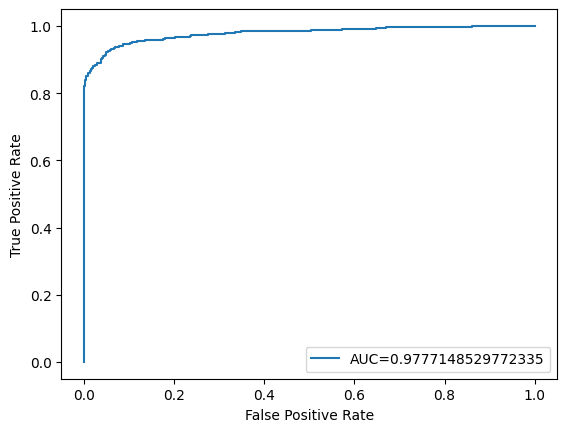

In [15]:
gradBoost = pickle.load(open('models/nardus_testing/gradBoost.pkl', 'rb'))
cols_when_model_builds = gradBoost.feature_names_in_
X_test_temp=X_test_temp[cols_when_model_builds]

print(accuracy_score(y_test_temp, gradBoost.predict(X_test_temp)).ravel())

print(confusion_matrix(y_test_temp, gradBoost.predict(X_test_temp)).ravel())

# ALWAYS reset X columns to the right order
y_thing = y_test_temp.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, gradBoost.predict_proba(X_test_temp)[::,1])
aaa = auc(recall, precision)

print("precision recall: " + str(aaa))

y_pred_proba = gradBoost.predict_proba(X_test_temp)[::,1]
fpr, tpr, _ = roc_curve(y_test_temp, y_pred_proba)
auc_thing = roc_auc_score(y_test_temp, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
lr_list = [0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,0.7, 0.75, 0.8, 0.85, 1]

parameters={
   "n_estimators":100, # 200 kind of overfits I think
    "max_features":2,
    "max_depth":8,
    "random_state":0,
    "subsample":0.8,
    'lambda': 0.5, # regularization?
    'alpha': 0.5
}



for learning_rate in lr_list:
    xgBoost = XGBClassifier(n_estimators=parameters['n_estimators'], 
    learning_rate=learning_rate, 
    max_depth=parameters['max_depth'], random_state=parameters['random_state'], 
    subsample=parameters['subsample'], 
    )

    parameters['learning_rate']=learning_rate
    xgBoost.fit(X_train, y_train)

    # ALWAYS reset feature names
    cols_when_model_builds = xgBoost.get_booster().feature_names
    X_test=X_test[cols_when_model_builds]

    testingAcc = accuracy_score(y_test, xgBoost.predict(X_test))
    trainingAcc = accuracy_score(y_train, xgBoost.predict(X_train))
    
    print("Learning rate: ", learning_rate)
    # print("Accuracy score (training): {0:.3f}".format(trainingAcc))
    print("Accuracy score (validation): {0:.3f}".format(testingAcc))
    # print(f"Feature importance {gradBoost.feature_importances_}")

    # pickle.dump(gradBoost, open('gradBoost.pkl', 'wb'))
    # saveModel(xgBoost, "xgBoost", X_test, y_test, parameters, xgBoost=True, dir="synthetic_data_testing")

Learning rate:  0.05
Accuracy score (validation): 0.630
Learning rate:  0.075
Accuracy score (validation): 0.650
Learning rate:  0.1
Accuracy score (validation): 0.630
Learning rate:  0.15
Accuracy score (validation): 0.660
Learning rate:  0.2
Accuracy score (validation): 0.640
Learning rate:  0.25
Accuracy score (validation): 0.640
Learning rate:  0.3
Accuracy score (validation): 0.630
Learning rate:  0.35
Accuracy score (validation): 0.640
Learning rate:  0.4
Accuracy score (validation): 0.630
Learning rate:  0.45
Accuracy score (validation): 0.645
Learning rate:  0.5
Accuracy score (validation): 0.635
Learning rate:  0.55
Accuracy score (validation): 0.625
Learning rate:  0.6
Accuracy score (validation): 0.635
Learning rate:  0.65
Accuracy score (validation): 0.595
Learning rate:  0.7
Accuracy score (validation): 0.630
Learning rate:  0.75
Accuracy score (validation): 0.635
Learning rate:  0.8
Accuracy score (validation): 0.610
Learning rate:  0.85
Accuracy score (validation): 0.625

In [ ]:
randforest = pickle.load(open('curr_models/randforest.pkl', 'rb'))
print(accuracy_score(y_train, randforest.predict(X_train)))

0.62375


In [ ]:
knn = pickle.load(open('curr_models/knn.pkl', 'rb'))

print(accuracy_score(y_test, knn.predict(X_test)))
# knn = KNeighborsClassifier(n_neighbors=5)

0.67


In [ ]:
def getSingleSequence(accessionID):
    try:
        QueryHandle = Entrez.efetch(db="nucleotide", id=accessionID, 
                                    rettype="gb", retmode="text")
    except HTTPError as Error:
        if Error.code == 400:  # Bad request
            raise ValueError(f"Accession number not found: {accessionID}")
        else:
            raise

    SeqRec = SeqIO.read(QueryHandle, "genbank")
    print(str(SeqRec))

    oDict = assign_kmers_to_dict(X_info, permset, kmer) # convert ordereddict to pandas dataframe

    kmer_df = pd.DataFrame()

    for i in oDict:
        kmer_df.at[0, i]=oDict[i]
    # print(best_gradBoost.predict_proba(kmer_df))

    cols_when_model_builds = best_gradBoost.feature_names_in_
    kmer_df=kmer_df[cols_when_model_builds]
    
    print([round(x, 2) for x in best_gradBoost.predict_proba(kmer_df).tolist()[0]])
    print(best_gradBoost.predict(kmer_df).tolist()[0])

    # ls = []
    # ls.append({'accession': accessionID, 'sequence': str(SeqRec.seq).lower()})
    # df = pd.DataFrame(ls)
    # print(df)

getSingleSequence("PA544053")

ID: PA544053.1
Name: PA544053
Description: WO 2022071435-A/1: SARS-CoV-2 PROTEIN-DERIVED PEPTIDES AND VACCINES INCLUDING THE SAME
Number of features: 1
/molecule_type=DNA
/topology=linear
/data_file_division=PAT
/date=29-JUL-2022
/accessions=['PA544053']
/sequence_version=1
/keywords=['WO 2022071435-A/1']
/source=Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)
/organism=Severe acute respiratory syndrome coronavirus 2
/taxonomy=['Viruses', 'Riboviria', 'Orthornavirae', 'Pisuviricota', 'Pisoniviricetes', 'Nidovirales', 'Cornidovirineae', 'Coronaviridae', 'Orthocoronavirinae', 'Betacoronavirus', 'Sarbecovirus']
/references=[Reference(title='SARS-CoV-2 PROTEIN-DERIVED PEPTIDES AND VACCINES INCLUDING THE SAME', ...)]
/comment=OS   Severe acute respiratory syndrome coronavirus 2 PN   WO
2022071435-A/1
PD   07-APR-2022
PF   29-SEP-2021 WO 2021JP035967
PR   30-SEP-2020 JP 2020-164630         ,30-APR-2021 JP
PR   JP2021/017159       ,
PR   25-AUG-2021 US 63/236927
PA   ONCOTHERAPY 